In [2]:
# 데이터 로딩 및 확인
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import math

offer_df = pd.read_csv('offerings.csv')
review_df = pd.read_csv('reviews.csv')

In [3]:
# 1. offerings
offer_df['name'].nunique() #4254
offer_df['name'].count() #4333
# 호텔이름이 같아도 지역이 다를 수 있고, 호텔이름 지역까지 같아도 구체적인 위치가 다를 수 있음 -> id로 구분
offer_df['id'].nunique() #4333

offer_df.drop(['phone', 'details', 'url', 'address', 'type', 'name'], axis=1, inplace=True)
offer_df.isna().sum()
offer_df

,hotel_class,region_id,id
0,4.0,60763,113317
1,5.0,32655,76049
2,3.5,60763,99352
3,4.0,60763,93589
4,4.0,60763,217616
...,...,...,...
4328,5.0,28970,84090
4329,5.0,28970,84065
4330,4.0,28970,84093
4331,4.5,28970,235513


In [4]:
# 2. reviews
review_df.isna().sum() #date_stayed: date열이랑 매칭이 안되는 것들도 있는데?
review_df[['author', 'offering_id']].head(10) 
review_df[review_df['offering_id']==1762573]['author'].value_counts().to_frame() #offering_id는 리뷰 제공매체로 추측 --> 호텔
review_df[['author', 'id']].sort_values('id', ascending=False).head(20)
review_df['id'].nunique() #878561
review_df['id'].count() #878561 --> 같은 사람이 작성한 리뷰는 없나?
review_df['via_mobile'] #mobile의 비중이 압도적으로 낮은건 해당 데이터가 2012년 이전 데이터이기 때문
review_df['date'].min() #2001-02-28
review_df['date'].max() #2012-12-20
review_df['num_helpful_votes'].value_counts() #해당 리뷰가 도움이 됐다고 표시한 갯수로 추측
review_df.drop(['author', 'date_stayed', 'num_helpful_votes', 'via_mobile', 'id'], axis=1, inplace=True)
review_df

# ratings
# title, text > text분석

,ratings,title,text,offering_id,date
0,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...","“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,93338,2012-12-17
1,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",93338,2012-12-17
2,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Great Stay”,This is a great property in Midtown. We two di...,1762573,2012-12-18
3,"{'service': 5.0, 'cleanliness': 5.0, 'overall'...",“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,1762573,2012-12-17
4,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,1762573,2012-12-17
...,...,...,...,...,...
878556,{'overall': 4.0},“vil komme igen”,"Pænt hotel i et livligt miljø. Store værelser,...",84093,2008-08-31
878557,"{'service': 4.0, 'cleanliness': 5.0, 'overall'...",“excellent”,"un excellent hotel 4 *, pour un prix raisonnab...",84093,2008-07-18
878558,"{'cleanliness': 5.0, 'overall': 5.0, 'rooms': ...",“Un hotel eccezionale”,"L'hotel, situato in una zona tranquilla e a du...",84093,2008-04-18
878559,"{'cleanliness': 5.0, 'overall': 5.0, 'rooms': ...",“Gerne wieder”,Sehr schön ausgestattetes Hotel in bester Lage...,84093,2008-04-01


In [5]:
# 3. data merge (리뷰당 한 행)
df = pd.merge(left=review_df, right=offer_df, how='left', right_on='id', left_on='offering_id')
df.isna().sum() #hotel_class: 34,937행
df.count() #전체 행: 878,561행

ratings        878561
title          878561
text           878561
offering_id    878561
date           878561
hotel_class    843624
region_id      878561
id             878561
dtype: int64

In [6]:
# deconstruct json columns
json_cols = ['ratings']

def clean_json(x):
    "Create apply function for decoding JSON"
    return json.loads(x)
for x in json_cols:
    df[x] = df[x].str.replace('\'','"')
    df[x] = df[x].apply(clean_json)

normalized_cols = pd.json_normalize(df['ratings'])
df = df.join(normalized_cols)
df = df.drop(json_cols, axis=1)
df

,title,text,offering_id,date,hotel_class,region_id,id,service,cleanliness,overall,value,location,sleep_quality,rooms,check_in_front_desk,business_service_(e_g_internet_access)
0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,93338,2012-12-17,3.0,60763,93338,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN
1,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",93338,2012-12-17,3.0,60763,93338,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN
2,“Great Stay”,This is a great property in Midtown. We two di...,1762573,2012-12-18,4.0,60763,1762573,4.0,5.0,4.0,4.0,5.0,4.0,4.0,NaN,NaN
3,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,1762573,2012-12-17,4.0,60763,1762573,5.0,5.0,4.0,5.0,5.0,5.0,5.0,NaN,NaN
4,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,1762573,2012-12-17,4.0,60763,1762573,4.0,5.0,4.0,3.0,5.0,5.0,5.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878556,“vil komme igen”,"Pænt hotel i et livligt miljø. Store værelser,...",84093,2008-08-31,4.0,28970,84093,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
878557,“excellent”,"un excellent hotel 4 *, pour un prix raisonnab...",84093,2008-07-18,4.0,28970,84093,4.0,5.0,4.0,4.0,4.0,NaN,5.0,5.0,NaN
878558,“Un hotel eccezionale”,"L'hotel, situato in una zona tranquilla e a du...",84093,2008-04-18,4.0,28970,84093,5.0,5.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN
878559,“Gerne wieder”,Sehr schön ausgestattetes Hotel in bester Lage...,84093,2008-04-01,4.0,28970,84093,5.0,5.0,5.0,NaN,NaN,NaN,5.0,NaN,NaN


In [7]:
df.isna().sum()
df.drop(['check_in_front_desk', 'business_service_(e_g_internet_access)', 'service', 'cleanliness', 'value', 'location', 'sleep_quality', 'rooms', 'id'], axis=1, inplace=True)
df

,title,text,offering_id,date,hotel_class,region_id,overall
0,"“Truly is ""Jewel of the Upper Wets Side""”",Stayed in a king suite for 11 nights and yes i...,93338,2012-12-17,3.0,60763,5.0
1,“My home away from home!”,"On every visit to NYC, the Hotel Beacon is the...",93338,2012-12-17,3.0,60763,5.0
2,“Great Stay”,This is a great property in Midtown. We two di...,1762573,2012-12-18,4.0,60763,4.0
3,“Modern Convenience”,The Andaz is a nice hotel in a central locatio...,1762573,2012-12-17,4.0,60763,4.0
4,“Its the best of the Andaz Brand in the US....”,I have stayed at each of the US Andaz properti...,1762573,2012-12-17,4.0,60763,4.0
...,...,...,...,...,...,...,...
878556,“vil komme igen”,"Pænt hotel i et livligt miljø. Store værelser,...",84093,2008-08-31,4.0,28970,4.0
878557,“excellent”,"un excellent hotel 4 *, pour un prix raisonnab...",84093,2008-07-18,4.0,28970,4.0
878558,“Un hotel eccezionale”,"L'hotel, situato in una zona tranquilla e a du...",84093,2008-04-18,4.0,28970,5.0
878559,“Gerne wieder”,Sehr schön ausgestattetes Hotel in bester Lage...,84093,2008-04-01,4.0,28970,5.0


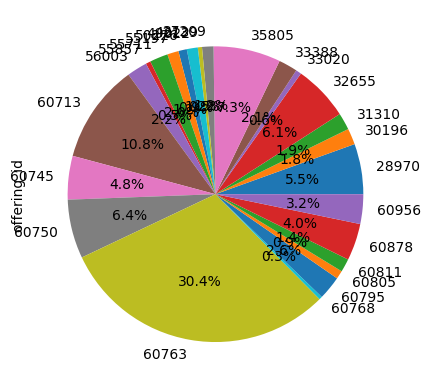

<Figure size 500x2000 with 0 Axes>

In [27]:
# EDA
# 1. 지역별 호텔 분포
df['region_id'].nunique() #25
df[['region_id', 'offering_id']].groupby('region_id').count().plot(kind='pie', autopct='%.1f%%', legend=None, subplots=True)
plt.figure(figsize=(5, 20))
plt.show()
# 60763 (New York City)에 가장 많은 호텔이 존재 > 60713 (San Francisco) > 35805 (Chicago)

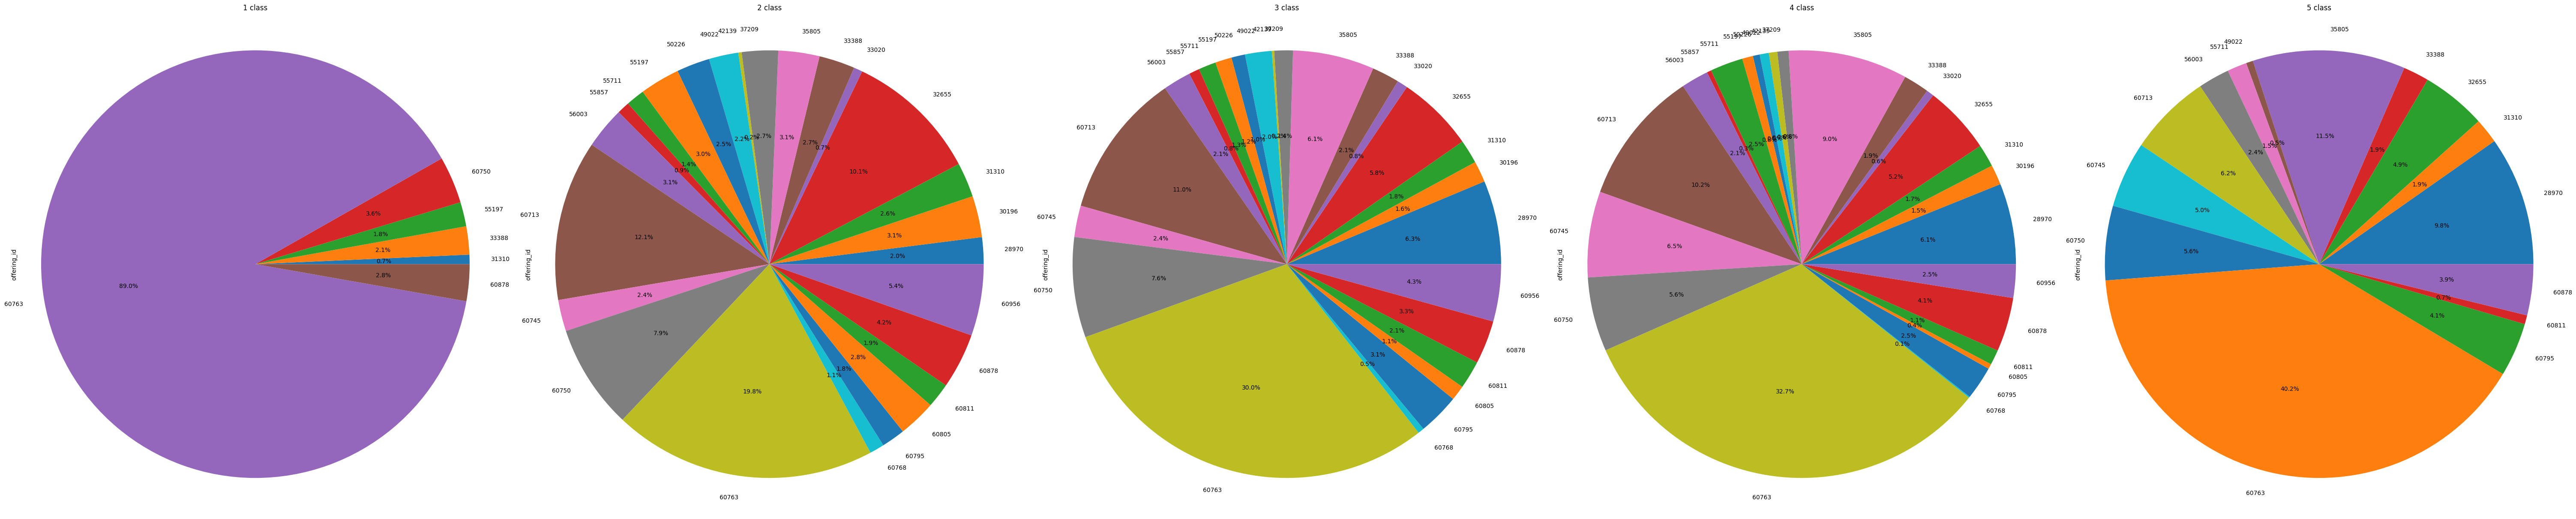

In [43]:
# 2. hotel_class별 지역 분포 (1부터 5까지, 0.5단위)
df['hotel_class'] = df['hotel_class'].round()
df['hotel_class'].value_counts().to_frame()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(60, 12), constrained_layout=True)
for i in range(1, 6):
    class_df = df[df['hotel_class']==i]
    class_df[['region_id', 'offering_id']].groupby('region_id').count().plot(kind='pie', autopct='%.1f%%', legend=None, subplots=True, ax=axes[i-1])
    axes[i-1].set_title(str(i)+" class")
    axes[i-1].axis('equal')
plt.show()
# 1성급: 60763 (New York City) 89%로 압도적
# 2성급: 60763 (New York City) > 60713 (San Francisco) > 32655 (Los Angeles)
# 3성급: 60763 (New York City) > 60713 (San Francisco)
# 4성급: 60763 (New York City) > 60713 (San Francisco) > 35805 (Chicago)
# 5성급: 60763 (New York City) > 35805 (Chicago) > 28970 (Washington DC)
# 더 높은 class일수록 60763이 차지하는 비율이 높아짐 (1성급 제외)
# chicago, washingto DC의 경우 5성급 호텔이 주로 포진되어있는 지역으로 확인

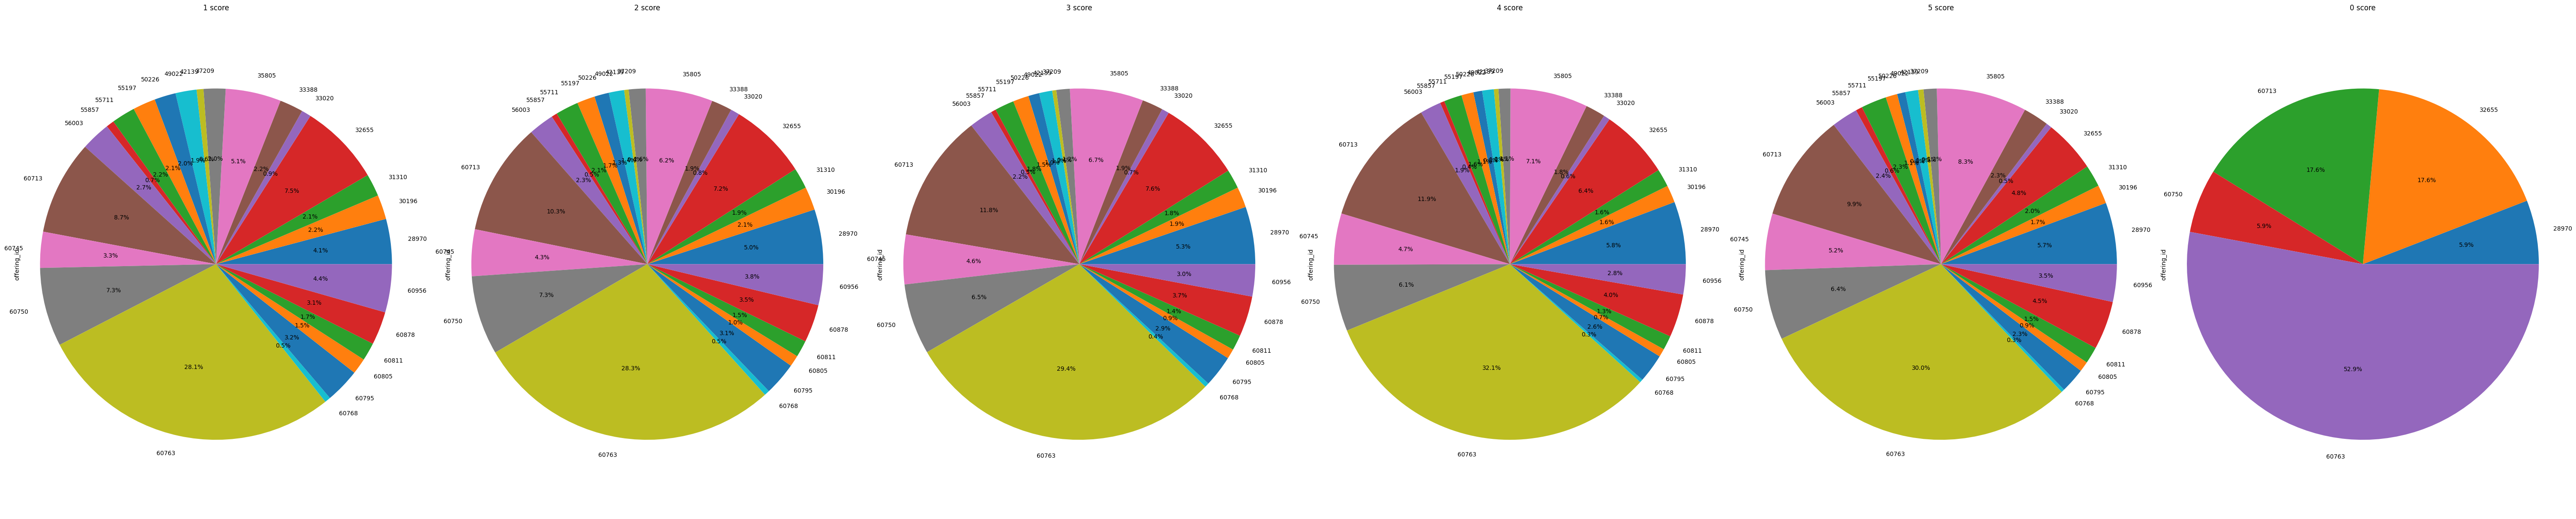

In [42]:
# 3. hotel review score별 지역 분포
df['overall'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(60, 12), constrained_layout=True)
for i in range(0, 6):
    score_df = df[df['overall']==i]
    score_df[['region_id', 'offering_id']].groupby('region_id').count().plot(kind='pie', autopct='%.1f%%', legend=None, subplots=True, ax=axes[i-1])
    axes[i-1].set_title(str(i)+" score")
    axes[i-1].axis('equal')
plt.show()
# 전반적으로 비슷한 패턴

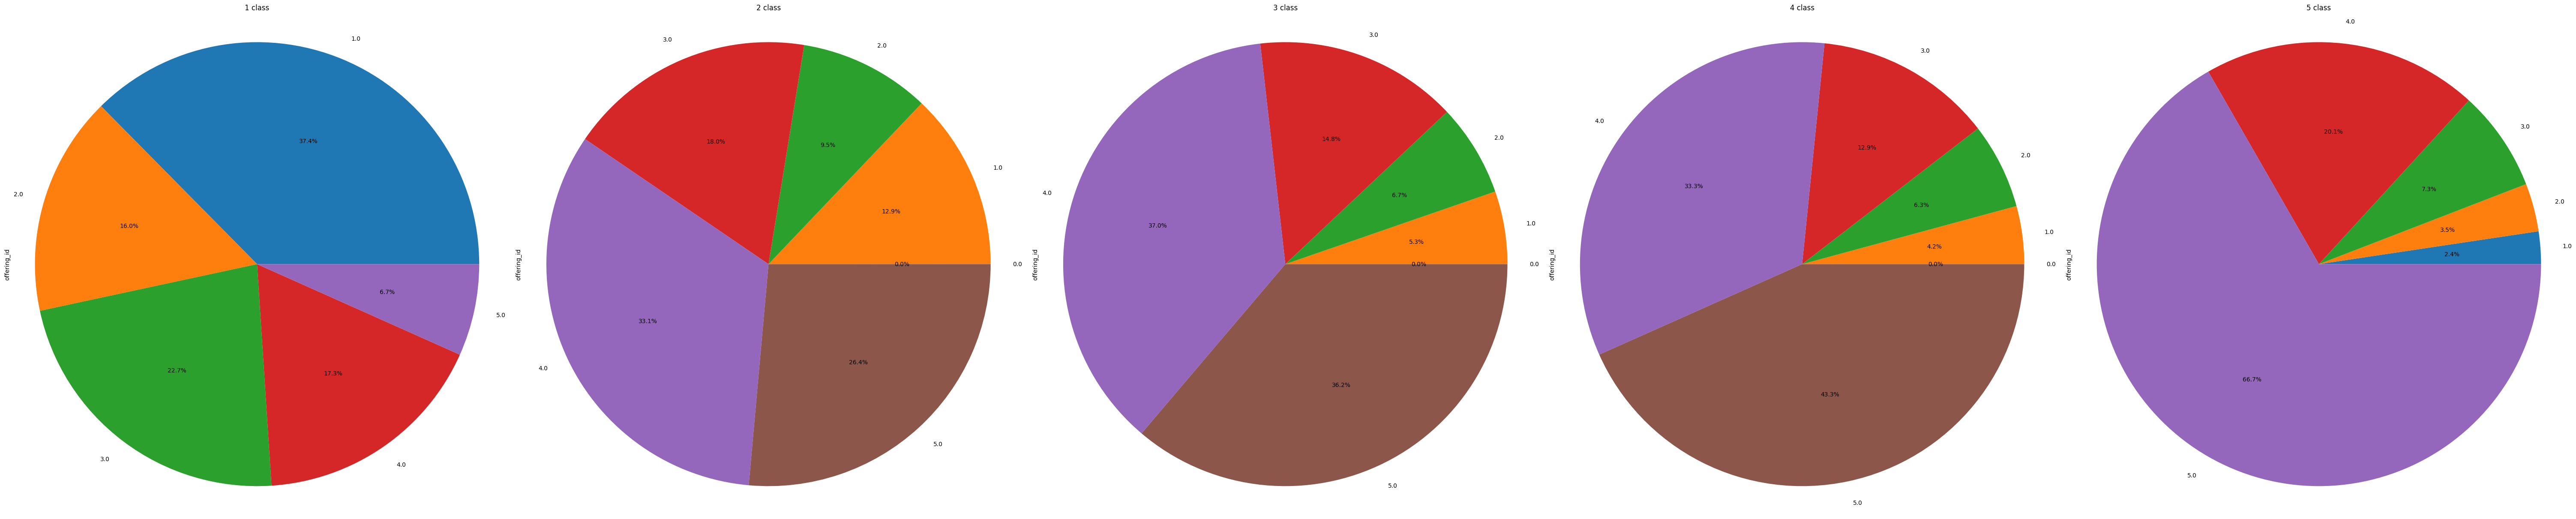

In [45]:
# 4. hotel class별 review score
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(60, 12), constrained_layout=True)
for i in range(1, 6):
    class_df = df[df['hotel_class']==i]
    class_df[['overall', 'offering_id']].groupby('overall').count().plot(kind='pie', autopct='%.1f%%', legend=None, subplots=True, ax=axes[i-1])
    axes[i-1].set_title(str(i)+" class")
    axes[i-1].axis('equal')
plt.show()
# 1성급: 1점이 압도적 (37.4%)
# 2, 3, 4성급 모두 4-5점이 50%이상 차지하고 있으며, class가 높을수록 5점의 비중이 높다.
# 5성급: 5점이 66.7%로 압도적이다. (5점+4점이 85% 이상)

In [56]:
# 5. 월별 호텔 이용 빈도
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['date'].dt.month.value_counts().to_frame().sort_values('date')
# 7-10월 사이의 이용이 가장 빈번하게 일어남

,count
date,
1,55867
2,47753
3,59101
4,66969
5,66284
6,75498
7,93315
8,97481
9,87744
